# Bayesian parameter estimation for an irregularly, noisily, and partially sampled non-linear SDE (Lorenz 63 w/ diffusion) via auto-differentiable non-linear filtering and HMC

We show how to use the [blackjax](https://github.com/blackjax-devs/blackjax) libray to compute the parameter posterior $p(\theta|y(1:T))$
for non-linear model. We use the Extended Kalman filter to compute the marginal likelihood, $p(y(1:T) | \theta) = \int_{z(1:T)} p(z(1:T), y(1:T)|\theta)$.



CURRENT CHALLENGE: understand the source of NaN losses and gradients when running SGD.
A resource: https://github.com/patrick-kidger/diffrax/issues/280

## Setup

In [2]:
import sys
%matplotlib inline
sys.path.append("../../..")
sys.path.append("../..")

import dynamax

from jax import numpy as jnp
from jax import vmap
import jax.random as jr
from matplotlib import pyplot as plt


# use custom src codebase
from utils.plotting_utils import *

# from utils.utils import monotonically_increasing
from continuous_discrete_nonlinear_gaussian_ssm import ContDiscreteNonlinearGaussianSSM
from continuous_discrete_nonlinear_gaussian_ssm.models import *

import blackjax


/opt/homebrew/anaconda3/envs/hduq_nodynamax/lib/python3.11/site-packages/equinox/_ad.py:733: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic zeros, which allow for more efficient autodifferentiation rules. In particular:
- the fwd and bwd functions take an extra `perturbed` argument, which     indicates which primals actually need a gradient. You can use this     to skip computing the gradient for any unperturbed value. (You can     also safely just ignore this if you wish.)
- `None` was previously passed to indicate a symbolic zero gradient for     all objects that weren't inexact arrays, but all inexact arrays     always had an array-valued gradient. Now, `None` may also be passed     to indicate that an inexact array has a symbolic zero gradient.
  warnings.warn(


In [3]:
from jax import random as  jr
from jax import numpy as jnp
from jax import jit, vmap
from itertools import count

from dynamax.parameters import log_det_jac_constrain

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [16, 9]

## Generate synthetic training data

In [4]:
# Simulate synthetic data from true model
state_dim = 3
emission_dim = 1
num_sequences = 1000
T = 1
num_timesteps = int(T / 0.01)
t_emissions = jnp.array(sorted(jr.uniform(jr.PRNGKey(0), (num_timesteps, 1), minval=0, maxval=T)))
# drop duplicates
t_emissions = jnp.unique(t_emissions)[:,None]
num_timesteps = len(t_emissions)
keys = map(jr.PRNGKey, count())

# Create a model with oscillatory dynamics
## GOAL is to only learn parameters of the drift function and assume all other parameters are known.


dynamics_drift = {
    "params": LearnableLorenz63(sigma=10.0, rho=28.0, beta=8/3),
    "props": LearnableLorenz63(sigma=ParameterProperties(),
                               rho=ParameterProperties(),
                               beta=ParameterProperties()) 
}

dynamics_diffusion_coefficient = {
    "params": LearnableMatrix(params=jnp.eye(state_dim)),
    "props": LearnableMatrix(params=ParameterProperties(trainable=False))
}

dynamics_diffusion_cov = {
    "params": LearnableMatrix(params=jnp.eye(state_dim)),
    "props": LearnableMatrix(params=ParameterProperties(constrainer=RealToPSDBijector(), trainable=False))
}

emission_function = {
    "params": LearnableLinear(weights=jnp.eye(emission_dim, state_dim), bias=jnp.zeros(emission_dim)),
    "props": LearnableLinear(weights=ParameterProperties(trainable=False), bias=ParameterProperties(trainable=False))
}

emission_cov = {
    "params": LearnableMatrix(params=jnp.eye(emission_dim)),
    "props": LearnableMatrix(params=ParameterProperties(constrainer=RealToPSDBijector(), trainable=False))
}

initial_mean = {"params": jnp.zeros(state_dim),
                "props": ParameterProperties(trainable=False)}

initial_cov = {"params": 100*jnp.eye(state_dim),
                "props": ParameterProperties(trainable=False, constrainer=RealToPSDBijector())}


true_model = ContDiscreteNonlinearGaussianSSM(state_dim, emission_dim)
true_params, true_props = true_model.initialize(
    next(keys),
    initial_mean=initial_mean,
    initial_cov=initial_cov,
    dynamics_drift=dynamics_drift,
    dynamics_diffusion_coefficient=dynamics_diffusion_coefficient,
    dynamics_diffusion_cov=dynamics_diffusion_cov,
    emission_function=emission_function,
    emission_cov=emission_cov,
)

# sample true states and emissions. Using transition_type="path" to solve SDE.
# true_states, emissions = true_model.sample(true_params, next(keys), num_timesteps, t_emissions)
# true_states, emissions = true_model.sample(true_params, next(keys), num_timesteps, t_emissions, transition_type="path")
true_states, emissions = true_model.sample_batch(
    true_params, next(keys), num_sequences, num_timesteps, t_emissions, transition_type="path"
)

# compute the log likelihood of the true model
## WARNING: only computing it for the first sequence
# this is to avoid batching for now...
first_emissions = emissions[0]
ll_true = true_model.marginal_log_prob(
    params=true_params, filter_hyperparams=EKFHyperParams(), emissions=first_emissions, t_emissions=t_emissions
)
print(f"Log likelihood of true model (approximated by EKF): {-ll_true}")

# normalize the emissions by subtracting the mean and dividing by the standard deviation
# emissions_std = emissions.std(axis=(0,1))
# emissions_mean = emissions.mean(axis=(0,1))
# emissions = (emissions - emissions_mean) / emissions_std

# normalize the states by subtracting the mean and dividing by the standard deviation
# true_states_std = true_states.std(axis=(0,1))
# true_states_mean = true_states.mean(axis=(0,1))
# true_states = (true_states - true_states_mean) / true_states_std

# compute normalized covariances
# emission_cov_normalized = {
#     "params": LearnableMatrix(params=emission_cov["params"].params / emissions_std**2),
#     "props": emission_cov["props"],
# }

# initial_cov_normalized = {
#     "params": jnp.eye(state_dim),
#     "props": initial_cov["props"]
# }

Sampling from SDE solver path (this may be an unnecessarily poor approximation if you're simulating from a linear SDE). It is an appropriate choice for non-linear SDEs.
Log likelihood of true model (approximated by EKF): 153.0345458984375


In [5]:
def plot_results(emissions, smoothed_emissions, smoothed_emissions_std):
    # all arrays are (T, E) dimensional, T=ntime, E=emission_dim
    spc = 3
    plt.figure(figsize=(10, 4))
    for i in range(emissions.shape[1]):
        plt.plot(emissions[:, i] + spc * i, "--k", label="observed" if i == 0 else None)
        ln = plt.plot(smoothed_emissions[:, i] + spc * i,
                    label="smoothed" if i == 0 else None)[0]
        plt.fill_between(
            jnp.arange(num_timesteps),
            spc * i + smoothed_emissions[:, i] - 2 * smoothed_emissions_std[:, i],
            spc * i + smoothed_emissions[:, i] + 2 * smoothed_emissions_std[:, i],
            color=ln.get_color(),
            alpha=0.25,
        )
    plt.xlabel("time")
    plt.xlim(0, num_timesteps - 1)
    plt.ylabel("true and predicted emissions")
    plt.legend()

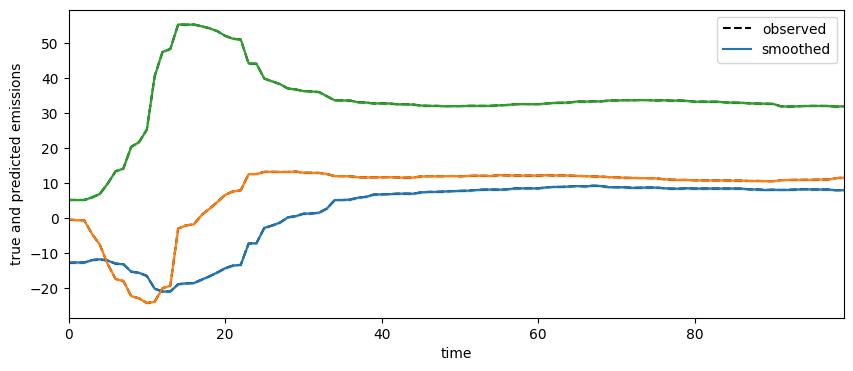

In [6]:
# plot results
plot_results(true_states[0], true_states[0], 0.1 * jnp.ones_like(true_states[0]))  # fake posterior variance

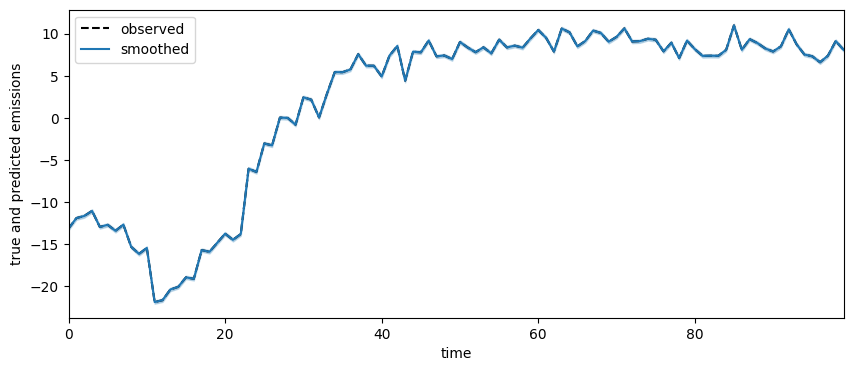

In [7]:
# plot results
plot_results(emissions[0], emissions[0], 0.1 * jnp.ones_like(emissions[0]))  # fake posterior variance

## Create a class for a learnable neural network, which we will use to parameterize the drift function

In [8]:
from typing import NamedTuple, Tuple, Optional, Union
from flax import linen as nn
from jax import jit

# define a normalizer class which stores the mean and standard deviation of the data
# it will have a method to normalize the data and another to denormalize it
class Normalizer(NamedTuple):
    mean: jnp.ndarray
    std: jnp.ndarray

    def normalize(self, data):
        return (data - self.mean) / self.std

    def denormalize(self, data):
        return data * self.std + self.mean

print("Warning: cheating by using the true states mean and std to normalize the states.")
my_normalizer = Normalizer(mean=true_states.mean(axis=(0,1)), std=true_states.std(axis=(0,1)))

@jit
def adjust_rhs(x, rhs, lower_bound=-100, upper_bound=100, espilon=1e-10):
    """
    Adjust the right-hand side of the ODE to ensure that the state 
    remains within the bounds [-100, 100]
    """

    ## NB: Can use jax.lax.clamp to do this more efficiently
    

    # Use a small epsilon to ensure numerical stability
    # Smoothly adjust the bounds to avoid gradient discontinuities
    # safe_lower_bound = jnp.where(x <= lower_bound, lower_bound + epsilon, x)
    # safe_upper_bound = jnp.where(x >= upper_bound, upper_bound - epsilon, x)

    # Conditionally adjust rhs using the safe bounds
    # rhs = jnp.where(safe_lower_bound <= lower_bound, jnp.maximum(rhs, 0), rhs)
    # rhs = jnp.where(safe_upper_bound >= upper_bound, jnp.minimum(rhs, 0), rhs)

    # adjust_min = x <= lower_bound
    # adjust_max = x >= upper_bound
    # rhs = jnp.where(adjust_min, jnp.maximum(rhs, 0), rhs)
    # rhs = jnp.where(adjust_max, jnp.minimum(rhs, 0), rhs)
    return rhs


class LearnableNN_TwoLayerGeLU(NamedTuple):
    """Two-layer neural network with Gaussian Error Linear Units
    weights1: weights of the first layer
    bias1: bias of the first layer
    weights2: weights of the second layer
    bias2: bias of the second layer

    f(x) = weights2 @ gelu(weights1 @ x + bias1) + bias2
    """

    weights1: Union[Float[Array, "hidden_dim input_dim"], ParameterProperties]
    bias1: Union[Float[Array, "hidden_dim"], ParameterProperties]
    weights2: Union[Float[Array, "output_dim hidden_dim"], ParameterProperties]
    bias2: Union[Float[Array, "output_dim"], ParameterProperties]
    scale: Union[Float, ParameterProperties]

    def f(self, x, u=None, t=None):
        '''This rhs operates in original space, so we need to normalize the input x first.'''

        # # first, clamp all x components to be within [-100, 100]
        # x = jnp.clip(x, -100, 100)
        x_normalized = my_normalizer.normalize(x)

        # compute derivative given by NN
        rhs = self.weights2 @ nn.gelu(self.weights1 @ x_normalized + self.bias1) + self.bias2

        # un-normalize the rhs and multiply by 10^scale
        rhs = rhs * my_normalizer.std * jnp.power(10, self.scale)

        return adjust_rhs(x, rhs)

## Build initial weights and biases for Neural Network drift function

In [9]:
# Draw weights and biases from a normal distribution with hidden_dim=64, input_dim=state_dim, output_dim=state_dim
hidden_dim = 50
nn_drift = {
    "params": LearnableNN_TwoLayerGeLU(
        weights1=jnp.sqrt(2.0 / state_dim) * jr.normal(next(keys), (hidden_dim, state_dim)),
        bias1=jnp.zeros((hidden_dim,)),
        weights2=jnp.sqrt(2.0 / hidden_dim) * jr.normal(next(keys), (state_dim, hidden_dim)),
        bias2=jnp.zeros((state_dim,)),
        scale=jnp.zeros(())
    ),
    "props": LearnableNN_TwoLayerGeLU(
        weights1=ParameterProperties(trainable=True),
        bias1=ParameterProperties(trainable=True),
        weights2=ParameterProperties(trainable=True),
        bias2=ParameterProperties(trainable=True),
        scale=ParameterProperties(trainable=True)
    ),
}

## Baseline method: use SGD to compute MLE

In [10]:
# Initilize parameters by fitting SGD algorithm
from continuous_discrete_nonlinear_gaussian_ssm import cdnlgssm_filter
from continuous_discrete_nonlinear_gaussian_ssm import *
from continuous_discrete_nonlinear_gaussian_ssm.models import *
num_epochs = 20

# filter_hyperparams = EnKFHyperParams(N_particles=30)
filter_hyperparams = EKFHyperParams(state_order='first')

test_model = ContDiscreteNonlinearGaussianSSM(state_dim, emission_dim)

initial_params, param_props = test_model.initialize(
    next(keys),
    initial_mean=initial_mean,
    initial_cov=initial_cov,
    dynamics_drift=nn_drift, # ONLY DIFFERENCE FROM TRUE MODEL
    dynamics_diffusion_coefficient=dynamics_diffusion_coefficient,
    dynamics_diffusion_cov=dynamics_diffusion_cov,
    emission_function=emission_function,
    emission_cov=emission_cov,
)

import optax

# define a learning rate scheduler
initial_learning_rate = 1e-1
decay_factor = 0.1  # Decay the learning rate by a factor of 10
epochs_per_step = 25  # Number of epochs per decay step

# Define the boundaries where the decay should happen
# In this case, every 20 epochs
boundaries = [epochs_per_step * i for i in range(1, num_epochs // epochs_per_step + 1)]

# Define the values of the learning rates at each boundary
values = [initial_learning_rate * (decay_factor**i) for i in range(len(boundaries) + 1)]

# Create a step decay learning rate schedule
scheduler = optax.piecewise_constant_schedule(
    init_value=initial_learning_rate, boundaries_and_scales={boundary: decay_factor for boundary in boundaries}
)

# define an optimizer with a learning rate of 1e-1 and gradient clipping
optimizer = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.scale_by_adam(),
    optax.scale_by_schedule(scheduler),  # Use the learning rate from the scheduler.
    optax.scale(-1.0),
)

fitted_params, fitted_params_history, grad_history, marginal_lls = true_model.fit_sgd(
    # true_params,
    # true_props,
    initial_params,
    param_props,
    emissions,
    filter_hyperparams=filter_hyperparams,
    t_emissions=t_emissions,
    num_epochs=num_epochs,
    optimizer=optimizer,
    return_param_history=True,
    return_grad_history=True,
    batch_size=num_sequences,
)

In [11]:
fitted_params_history.dynamics.drift.scale

Array([-0.09999924, -0.02862773, -0.0717868 , -0.05433143, -0.01025004,
        0.04920347,  0.11300036,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan],      dtype=float32)

In [12]:
marginal_lls

Array([11.577886 , 10.666086 ,  9.015785 ,  8.516655 ,  7.627711 ,
        6.453806 ,  5.4231987,  4.9134307,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan],      dtype=float32)

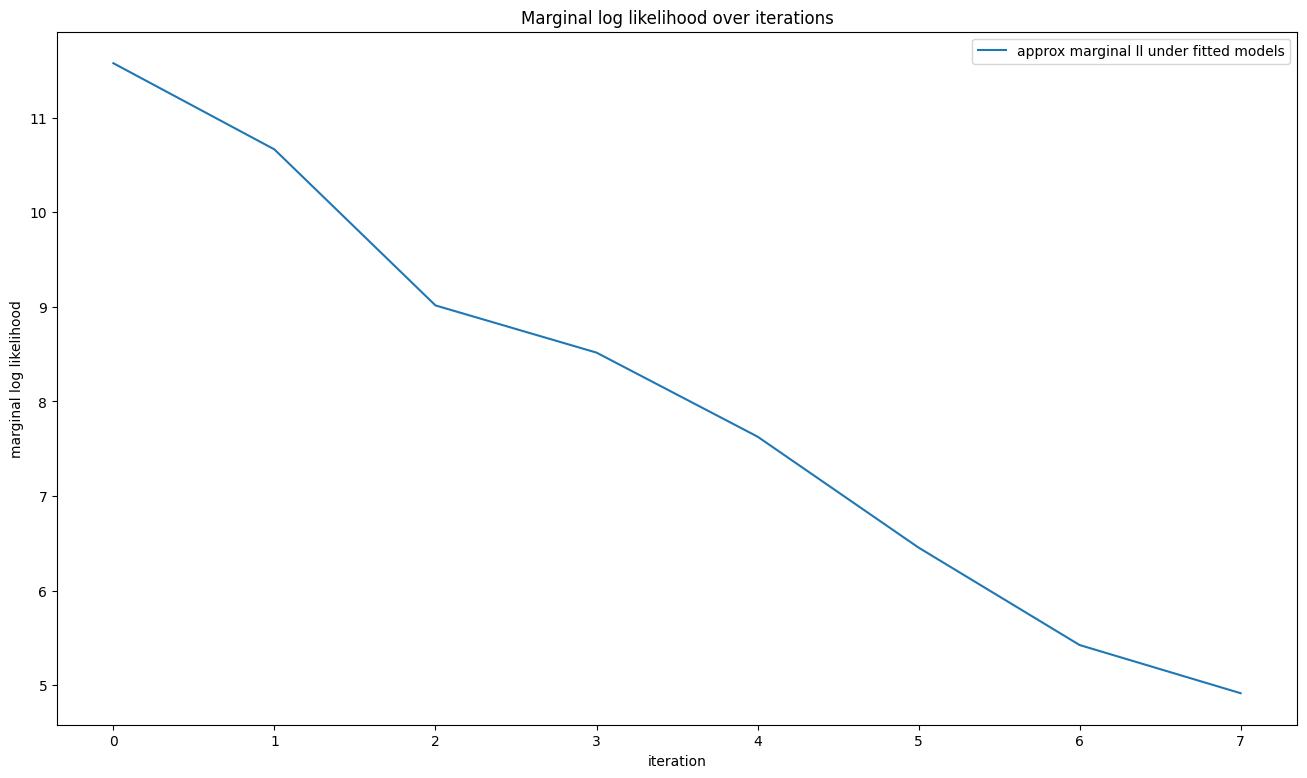

In [13]:
# plot the marginal lls over iterations for SGD
plt.plot(marginal_lls, label="approx marginal ll under fitted models")
# plt.axhline(-ll_true, color="red", linestyle="--", label="approx marginal ll under true model")
plt.xlabel("iteration")
plt.ylabel("marginal log likelihood")
# plt.autoscale(enable=True, axis="x", tight=True)
plt.title("Marginal log likelihood over iterations")
plt.legend()


In [14]:
t_emissions.shape

(100, 1)

In [18]:
# def clip_by_value(clip_value_min, clip_value_max):
#     def transformation(updates):
#         return tree_map(lambda g: jnp.clip(g, clip_value_min, clip_value_max), updates)
#     return transformation

def clip_by_value(min_val, max_val):
    def init_fn(params):
        # This transformation does not need state initialization
        return None

    def update_fn(updates, state, params=None):
        clipped_updates = tree_map(lambda g: jnp.clip(g, min_val, max_val), updates)
        return clipped_updates, state

    return optax.GradientTransformation(init_fn, update_fn)


optimizer = optax.chain(
    clip_by_value(0, 0),
    optax.scale_by_adam(eps=1e-1),
    optax.scale(-0.0),
)

# Re-run 1 epoch of SGD to see if it still switches to NAN
fitted_params2, fitted_params_history2, grad_history2, marginal_lls2 = test_model.fit_sgd(
    # true_params,
    # true_props,
    tree_map(lambda x: x[6], fitted_params_history),
    param_props,
    emissions,
    filter_hyperparams=filter_hyperparams,
    t_emissions=t_emissions,
    num_epochs=1,
    optimizer=optimizer,
    return_param_history=True,
    return_grad_history=True,
    batch_size=num_sequences,
)
print(marginal_lls2)
print(fitted_params2)

[4.9134307]
ParamsCDNLGSSM(initial=ParamsLGSSMInitial(mean=Array([0., 0., 0.], dtype=float32), cov=Array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 100.]], dtype=float32)), dynamics=ParamsCDNLGSSMDynamics(drift=LearnableNN_TwoLayerGeLU(weights1=Array([[nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [na

In [20]:
grad_history2

ParamsCDNLGSSM(initial=ParamsLGSSMInitial(mean=Array([[0., 0., 0.]], dtype=float32), cov=Array([[0., 0., 0., 0., 0., 0.]], dtype=float32)), dynamics=ParamsCDNLGSSMDynamics(drift=LearnableNN_TwoLayerGeLU(weights1=Array([[[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan,

In [16]:
tree_map(lambda x: x[12], fitted_params_history)

ParamsCDNLGSSM(initial=ParamsLGSSMInitial(mean=Array([nan, nan, nan], dtype=float32), cov=Array([[nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan]], dtype=float32)), dynamics=ParamsCDNLGSSMDynamics(drift=LearnableNN_TwoLayerGeLU(weights1=Array([[nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
    

In [25]:
from dynamax.parameters import to_unconstrained, from_unconstrained, log_det_jac_constrain
from dynamax.utils.utils import ensure_array_has_batch_dim, pytree_stack
from jax import lax, value_and_grad, tree_map

params = tree_map(lambda x: x[6], fitted_params_history)

batch_inputs = ensure_array_has_batch_dim(None, test_model.inputs_shape)
batch_emissions = ensure_array_has_batch_dim(emissions, test_model.emission_shape)
# batch_t_emissions = ensure_array_has_batch_dim(t_emissions, (1,))
batch_t_emissions = jnp.repeat(t_emissions[jnp.newaxis, :, :], batch_emissions.shape[0], axis=0)

# duplicate t_emissions for each sequence
# batch_t_emissions = jnp.tile(t_emissions, (num_sequences, 1, 1))
def _loss_fn(my_params):
    batch_lls = vmap(
        partial(test_model.marginal_log_prob, my_params, filter_hyperparams=filter_hyperparams),
    )(emissions=batch_emissions, t_emissions=batch_t_emissions, inputs=batch_inputs)
    lp = test_model.log_prior(my_params) + batch_lls.sum()
    return -lp / len(batch_emissions)

loss_grad_fn = value_and_grad(_loss_fn)
this_loss, grads = loss_grad_fn(params)
print(this_loss)
print(jnp.max(jnp.abs(grads.dynamics.drift.bias2)))
print(jnp.max(jnp.abs(grads.dynamics.drift.bias1)))
print(jnp.max(jnp.abs(grads.dynamics.drift.weights1)))
print(jnp.max(jnp.abs(grads.dynamics.drift.weights2)))

491.34293
nan
nan
nan
nan


In [ ]:
from dynamax.parameters import to_unconstrained, from_unconstrained, log_det_jac_constrain
from dynamax.utils.utils import ensure_array_has_batch_dim, pytree_stack
from jax import lax, value_and_grad, tree_map

params = tree_map(lambda x: x[4], fitted_params_history)

batch_inputs = ensure_array_has_batch_dim(None, test_model.inputs_shape)
batch_emissions = ensure_array_has_batch_dim(emissions, test_model.emission_shape)
# batch_t_emissions = ensure_array_has_batch_dim(t_emissions, (1,))
batch_t_emissions = jnp.repeat(t_emissions[jnp.newaxis, :, :], batch_emissions.shape[0], axis=0)


# duplicate t_emissions for each sequence
# batch_t_emissions = jnp.tile(t_emissions, (num_sequences, 1, 1))
T = 100
dt = 0.01
num_timesteps_long = int(T / dt)
t_emissions_long = jnp.array(sorted(jr.uniform(jr.PRNGKey(0), (num_timesteps, 1), minval=0, maxval=T)))

def _loss_fn(my_params):
    states, emissions = test_model.sample(
        my_params,
        key=next(keys),
        num_timesteps=num_timesteps_long,
        t_emissions=t_emissions_long,
        transition_type="path",
    )
    return emissions.mean()

loss_grad_fn = value_and_grad(_loss_fn)
this_loss, grads = loss_grad_fn(params)
print(this_loss)
print(jnp.max(jnp.abs(grads.dynamics.drift.bias2)))
print(jnp.max(jnp.abs(grads.dynamics.drift.bias1)))
print(jnp.max(jnp.abs(grads.dynamics.drift.weights1)))
print(jnp.max(jnp.abs(grads.dynamics.drift.weights2)))

In [ ]:
batch_inputs = ensure_array_has_batch_dim(None, test_model.inputs_shape)
batch_emissions = ensure_array_has_batch_dim(emissions[30:40], test_model.emission_shape)
# batch_t_emissions = ensure_array_has_batch_dim(t_emissions, (1,))
batch_t_emissions = jnp.repeat(t_emissions[jnp.newaxis, :, :], batch_emissions.shape[0], axis=0)


filtered_posterior = cdnlgssm_filter(
    params=params,
    emissions=emissions[40],
    hyperparams=filter_hyperparams,
    t_emissions=t_emissions,
)

In [ ]:
jnp.min(jnp.abs(filtered_posterior.filtered_covariances[filtered_posterior.filtered_covariances!=0]))

In [ ]:
foo = emissions[30:40]
for i in range(10):
    plt.plot(foo[i])


In [ ]:
fitted_params_history2.dynamics.drift.scale

In [ ]:
fitted_params_history.dynamics.drift.scale


In [35]:
emissions.shape

(1000, 100, 1)

In [54]:
fitted_params_ind.dynamics.drift.weights1.shape

(50, 3)

In [56]:
emissions.shape

(1000, 100, 1)

In [69]:
ind = 6  # get the last fitted params
# in each tree element get the ind'th element
fitted_params_ind = tree_map(lambda x: x[ind], fitted_params_history)
# Extract fitted params
# fitted_C = fitted_params_ind.emissions.emission_function.weights
# fitted_d = fitted_params_ind.emissions.emission_function.bias
# fitted_R = fitted_params_ind.emissions.emission_cov.params

# Compute predicted emissions with vmap
# filtered_posterior = vmap(
#     lambda x: cdnlgssm_filter(fitted_params_ind, emissions=x, hyperparams=filter_hyperparams, t_emissions=t_emissions)
# )(emissions)


def _loss_fn(my_params, em):
    # return test_model.marginal_log_prob(
    #    params=my_params, filter_hyperparams=filter_hyperparams, emissions=emissions[0], t_emissions=t_emissions
    # )
    foo = cdnlgssm_filter(my_params, emissions=em, hyperparams=filter_hyperparams, t_emissions=t_emissions)
    return foo.marginal_loglik

# vmap over the emissions

# lls = vmap(value_and_grad(partial(loss_fn, fitted_params_ind), argnums=0))(emissions)
# loss_grad_fn = value_and_grad(loss_fn(fitted_params_ind))
loss_grad_fn = value_and_grad(partial(_loss_fn, em=emissions[0]))
this_loss, grads = loss_grad_fn(params)

print(this_loss)
print(jnp.max(grads.dynamics.drift.weights2))


# Compute value_and_grad of each filtered_posterior.marginall_loglik using vmap


foo = vmap(lambda em: value_and_grad(partial(_loss_fn, em=em))(params))(emissions)

# Compute value_and_grad of each filtered_posterior.marginall_loglik using vmap
# filtered_posterior_lls = vmap(
#     lambda x: value_and_grad(
#         lambda x: cdnlgssm_filter(fitted_params_ind, emissions=x, hyperparams=filter_hyperparams, t_emissions=t_emissions).marginal_loglik
#     )
# )(emissions)


# filtered_posterior = cdnlgssm_filter(
#     fitted_params, emissions=emissions, hyperparams=filter_hyperparams, t_emissions=t_emissions
# )
# filtered_emissions_mean = filtered_posterior.filtered_means @ fitted_C.T + fitted_d

# compute cov and std from this
# filtered_emissions_cov = filtered_posterior.filtered_covariances @ fitted_C.T + fitted_R  # (10, 3000, 3, 3)

# use vmap to compute std for each sequence
# filtered_emissions_std = vmap(lambda x: jnp.sqrt(jnp.array([x[:, i, i] for i in range(emission_dim)]).T))(filtered_emissions_cov)
# filtered_emissions_std # (10, 3000, 3)
# filtered_emissions_std = jnp.sqrt(jnp.array([filtered_emissions_cov[:, i, i] for i in range(emission_dim)]).T)  # (3, 10, 3)
# Need to compute std for each sequence


# filtered_emissions_cov = fitted_C @ filtered_posterior.filtered_covariances @ fitted_C.T + fitted_R
# filtered_emissions_std = jnp.sqrt(jnp.array([filtered_emissions_cov[:, i, i] for i in range(emission_dim)])).T  # (T,E)

-326.0382
379.0482


In [71]:
lls = foo[0]
grads = foo[1]

print(grads)
# find which index along 1st axis are NaN
# nan_idx = jnp.isnan(lls[1], axis=0)

ParamsCDNLGSSM(initial=ParamsLGSSMInitial(mean=Array([[-0.01531573,  4.416975  , -2.4917428 ],
       [-0.34034854, -3.5331786 , -0.5098048 ],
       [        nan,         nan,         nan],
       ...,
       [ 0.06295925,  0.70543   ,  0.03932225],
       [ 0.05973107,  5.8928447 , -1.1657263 ],
       [ 0.10244329,  0.30872563,  0.15990582]], dtype=float32), cov=Array([[[-9.7311744e-03, -2.0142303e+00, -7.2297108e-01],
        [ 1.4678388e+00,  1.5420204e-01,  4.0638304e-01],
        [ 1.0687662e+00,  4.0638304e-01, -2.0325471e-01]],

       [[ 2.7946565e-02, -1.1214955e+00,  1.9142463e+00],
        [ 1.5212784e+00, -3.0314249e-01, -2.8868014e-01],
        [-1.8985014e+00, -2.8868014e-01, -2.6300967e-01]],

       [[           nan,            nan,            nan],
        [           nan,            nan,            nan],
        [           nan,            nan,            nan]],

       ...,

       [[-3.0662632e-03, -2.0235227e-01, -2.5755224e-01],
        [ 2.3708530e-01,  2.95559

In [94]:
print(grads.dynamics.drift.weights1.shape)
nan_mask = jnp.isnan(grads.dynamics.drift.weights1)

nan_axis0_idx = jnp.where(nan_mask.any(axis=(1, 2)))[0]
print("First axis indices with NaNs: ", nan_axis0_idx)

nan_axis1_idx = jnp.where(nan_mask.any(axis=(0, 2)))[0]
print("Second axis indices with NaNs: ", nan_axis1_idx)

nan_axis2_idx = jnp.where(nan_mask.any(axis=(0, 1)))[0]
print("Third axis indices with NaNs: ", nan_axis2_idx)

(1000, 50, 3)
First axis indices with NaNs:  [  2  19  40  68  93 106 108 172 177 182 197 221 231 235 237 238 254 262
 268 282 290 298 299 305 340 363 366 372 392 394 403 475 496 514 516 521
 540 552 559 575 588 604 638 646 648 651 663 664 676 687 727 732 736 766
 772 800 814 819 825 850 851 862 905 909 924 930 949 975 978 982 983 990]
Second axis indices with NaNs:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
Third axis indices with NaNs:  [0 1 2]


In [98]:
## Let's focus on param[6] and emission[2] and see if we can find the NaNs
fitted_params_ind = tree_map(lambda x: x[6], fitted_params_history)

def _loss_fn(my_params):
    foo = cdnlgssm_filter(my_params, emissions=emissions[2], hyperparams=filter_hyperparams, t_emissions=t_emissions)
    return foo.marginal_loglik

loss_grad_fn = value_and_grad(_loss_fn)
this_loss, grads = loss_grad_fn(params)

print(this_loss)
print(grads)

-821.0489
ParamsCDNLGSSM(initial=ParamsLGSSMInitial(mean=Array([nan, nan, nan], dtype=float32), cov=Array([[nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan]], dtype=float32)), dynamics=ParamsCDNLGSSMDynamics(drift=LearnableNN_TwoLayerGeLU(weights1=Array([[nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, 

In [134]:
# Let's investigate the filtered_posterior for the 2nd emission sequence at param[6]
id_emission = 2
fitted_params_ind = tree_map(lambda x: x[6], fitted_params_history)
filtered_posterior = cdnlgssm_filter(
    fitted_params_ind, emissions=emissions[id_emission], hyperparams=filter_hyperparams, t_emissions=t_emissions
)
print("Number of NaNs in filtered_means: ", jnp.isnan(filtered_posterior.filtered_means).sum())
print("Number of NaNs in filtered_covariances: ", jnp.isnan(filtered_posterior.filtered_covariances).sum())
print("Number of NaNs in predicted means: ", jnp.isnan(filtered_posterior.predicted_means).sum())
print("Number of NaNs in predicted covariances: ", jnp.isnan(filtered_posterior.predicted_covariances).sum())
print("Number of NaNs in filtered_posterior.marginal_loglik: ", jnp.isnan(filtered_posterior.marginal_loglik).sum())

# Note that we only have Nans in the PREDICTED COVARIANCES
nan_mask = jnp.isnan(filtered_posterior.predicted_covariances)
nan_axis0_idx = jnp.where(nan_mask.any(axis=(1, 2)))[0]
print("First axis of predicted covariance indices with NaNs: ", nan_axis0_idx)

Number of NaNs in filtered_means:  0
Number of NaNs in filtered_covariances:  0
Number of NaNs in predicted means:  0
Number of NaNs in predicted covariances:  9
Number of NaNs in filtered_posterior.marginal_loglik:  0
First axis of predicted covariance indices with NaNs:  [99]


In [ ]:
print([emissions.shape, filtered_emissions_mean.shape, filtered_emissions_std.shape])
plot_results(emissions[0], filtered_emissions_mean[0], filtered_emissions_std[0])

In [ ]:
# now plot the true states and the filtered states, each in its own subplot
fig, axs = plt.subplots(state_dim, 1, figsize=(10, 8), sharex=True)
for i in range(state_dim):
    axs[i].plot(true_states[0, :, i], "--k", label="true" if i == 0 else None)
    axs[i].plot(filtered_posterior.filtered_means[0, :, i], label="filtered" if i == 0 else None)
    axs[i].set_ylabel(f"state {i}")
    if i == 0:
        axs[i].legend()
axs[-1].set_xlabel("time")

### Plot a long forward sim of the model---unless the model is trained well, this often decays to a fixed point or blows up

In [ ]:
sim_states, sim_emissions = test_model.sample_batch(
    fitted_params_ind, next(keys), num_sequences, num_timesteps, t_emissions, transition_type="path"
)

# now plot the true states and the filtered states, each in its own subplot
fig, axs = plt.subplots(state_dim, 1, figsize=(10, 8), sharex=True)
for i in range(state_dim):
    axs[i].plot(sim_states[0, :, i], "--k", label="true" if i == 0 else None)
    axs[i].set_ylabel(f"state {i}")
    if i == 0:
        axs[i].legend()
axs[-1].set_xlabel("time")

## Implement HMC wrapper

In [ ]:
@jit
def filter_emission(params):
    C = params.emissions.emission_function.weights
    d = params.emissions.emission_function.bias
    filtered_posterior = cdnlgssm_filter(
        params, emissions=emissions[0], hyperparams=filter_hyperparams, t_emissions=t_emissions
    )

    return filtered_posterior.filtered_means @ C.T + d    

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def plot_param_distributions(samples, true, sgd, name='', burn_in_frac=0.5):
    """
    Plots N_params horizontal box plots for the given N_params x N_samples matrix.

    Parameters:
    - samples: N_params x N_samples matrix of parameter samples.
    - true: N_params array of true parameter values.
    - sgd: N_params array of SGD estimates.
    - name: Name of the parameter set.
    - burn_in_frac: Fraction of samples to discard as burn-in.

    Returns:
    - A matplotlib figure with N_params horizontal box plots.
    """
    N_params = samples.shape[0]
    fig, ax = plt.subplots(figsize=(10, N_params * 2))  # Adjust figure size based on number of parameters

    # apply burn-in
    burn_in = int(burn_in_frac * samples.shape[1])
    samples = samples[:, burn_in:]
    
    # Create box plots
    ax.boxplot(samples, vert=False, patch_artist=True)

    # Set the y-axis labels to show parameter indices
    ax.set_yticks(range(1, N_params + 1))
    ax.set_yticklabels(["Parameter {}".format(i + 1) for i in range(N_params)])

    # Plot ground truth and estimates
    ax.scatter(sgd, range(1, N_params + 1), color="magenta", marker="o", s=100, label="SGD Estimate", zorder=3)
    ax.scatter(true, range(1, N_params + 1), color="red", marker="x", s=100, label="Ground Truth", zorder=4)

    plt.xlabel("Value")
    plt.ylabel("Parameters")
    plt.title("{} Parameter Distributions".format(name))
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_all(param_samples, burn_in_frac=0.5):
    """
    Plots the posterior distributions of all parameters.
    Burn-in is removed from the samples.
    """
    plot_param_distributions(
        param_samples.initial.mean.T, true_params.initial.mean, fitted_params.initial.mean, name="Initial mean",
        burn_in_frac=burn_in_frac
    )
    plot_param_distributions(
        param_samples.initial.cov.reshape(param_samples.initial.cov.shape[0], -1).T,
        true_params.initial.cov.flatten(),
        fitted_params.initial.cov.flatten(),
        name="Initial cov",
        burn_in_frac=burn_in_frac,
    )
    plot_param_distributions(
        param_samples.dynamics.drift.sigma.reshape(param_samples.dynamics.drift.sigma.shape[0], -1).T,
        true_params.dynamics.drift.sigma,
        fitted_params.dynamics.drift.sigma,
        name="Dynamics drift sigma",
        burn_in_frac=burn_in_frac,
    )
    plot_param_distributions(
        param_samples.dynamics.drift.rho.reshape(param_samples.dynamics.drift.rho.shape[0], -1).T,
        true_params.dynamics.drift.rho,
        fitted_params.dynamics.drift.rho,
        name="Dynamics drift rho",
        burn_in_frac=burn_in_frac,
    )
    plot_param_distributions(
        param_samples.dynamics.drift.beta.reshape(param_samples.dynamics.drift.beta.shape[0], -1).T,
        true_params.dynamics.drift.beta,
        fitted_params.dynamics.drift.beta,
        name="Dynamics drift beta",
        burn_in_frac=burn_in_frac,
    )
    plot_param_distributions(
        param_samples.dynamics.diffusion_cov.params.reshape(param_samples.dynamics.diffusion_cov.params.shape[0], -1).T,
        true_params.dynamics.diffusion_cov.params.flatten(),
        fitted_params.dynamics.diffusion_cov.params.flatten(),
        name="Dynamics diffusion cov",
        burn_in_frac=burn_in_frac,
    )
    plot_param_distributions(
        param_samples.dynamics.diffusion_coefficient.params.reshape(
            param_samples.dynamics.diffusion_coefficient.params.shape[0], -1
        ).T,
        true_params.dynamics.diffusion_coefficient.params.flatten(),
        fitted_params.dynamics.diffusion_coefficient.params.flatten(),
        name="Dynamics diffusion coefficient",
        burn_in_frac=burn_in_frac,
    )
    plot_param_distributions(
        param_samples.emissions.emission_function.weights.reshape(
            param_samples.emissions.emission_function.weights.shape[0], -1
        ).T,
        true_params.emissions.emission_function.weights.flatten(),
        fitted_params.emissions.emission_function.weights.flatten(),
        name="Emissions function weights",
        burn_in_frac=burn_in_frac,
    )
    plot_param_distributions(
        param_samples.emissions.emission_function.bias.reshape(
            param_samples.emissions.emission_function.bias.shape[0], -1
        ).T,
        true_params.emissions.emission_function.bias.flatten(),
        fitted_params.emissions.emission_function.bias.flatten(),
        name="Emissions function bias",
        burn_in_frac=burn_in_frac,
    )
    plot_param_distributions(
        param_samples.emissions.emission_cov.params.reshape(param_samples.emissions.emission_cov.params.shape[0], -1).T,
        true_params.emissions.emission_cov.params.flatten(),
        fitted_params.emissions.emission_cov.params.flatten(),
        name="Emissions cov",
        burn_in_frac=burn_in_frac,
    )

## Call HMC

In [ ]:
# Now, run HMC initialized using the SGD-fitted parameters
# param_samples, lps = test_model.fit_hmc(
#     fitted_params,
#     param_props,
#     emissions,
#     filter_hyperparams,
#     t_emissions,
#     inputs=None,
#     num_samples=500,
#     warmup_steps=10,
#     num_integration_steps=3,
#     key=next(keys)
# )

In [ ]:
plt.plot(lps)
plt.xlabel("iteration")
plt.xlabel("log probability")

In [ ]:
filtered_emissions = vmap(filter_emission)(param_samples)
filtered_emissions_mean = filtered_emissions.mean(axis=0)
filtered_emissions_std = jnp.std(filtered_emissions, axis=0)

# note that this shows a distribution of filtered means
# Unlike earlier plots, it does not show the filtered covariances, 
# which would add an appearance of greater uncertainty.
print([emissions.shape, filtered_emissions.shape, filtered_emissions_mean.shape, filtered_emissions_std.shape])
plot_results(emissions, filtered_emissions_mean, filtered_emissions_std)

In [ ]:
plot_all(param_samples)